In [36]:
import numpy as np
import pandas as pd
import pyarrow
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows',500)

In [53]:
rated_bookings_file = './Datasets/rated_bookings.csv'
rb=pd.read_csv(rated_bookings_file, index_col=0)
rb

,Unnamed: 0_booking,status,supplier,booking_id,roundtrip_id,name,pickup_date_booking,pickup_time,number_of_passenger_booking,vehicle_type,route_type,route,total_price,total_comission,total_driver,special_notes,city_of_departure,address,hotel,flight_number,last_update_date,booking_date,Unnamed: 0_rating,rating_text,country,rating_score,pickup_date_rating,rating_date,number_of_passenger_rating,vehicle,booking_departure,booking_destination
0,765,NaN,NewDay,T63989,NaN,Sylvia,2014-09-19 21:00:00,21:00,3,SUV6,Ciudad - Aeropuerto,Manhattan - Aeropuerto JFK,105.0,NaN,75.00,NaN,New York,200 West 56th street NYC 10019,the manhattan club,aeromexico am401,2023-11-01 10:45:00,2014-09-13 15:08:00,20178,Excelente servicio los choferes muy atentos y ...,es,5,2014-09-19 21:00:00,2014-09-25 13:36:00,3,Vehículo SUV de 6 plazas,Manhattan,Aeropuerto JFK
1,766,NaN,NewDay,T64049,NaN,Edgar,2014-09-15 22:35:00,22:35,5,SUV6,Aeropuerto - Ciudad,Aeropuerto JFK - Manhattan,120.0,NaN,90.00,NaN,PORT OF SPAIN (TRINIDAD),"790 Seventh Avenue at 51st Street New York, NY...",THE MANHATTAN AT TIMES SQUARE HOTEL,CARIBBEAN AIRLINES BW 424,2023-11-01 10:45:00,2014-09-13 15:08:00,20188,Excelente Servicio lo recomiendo 100%. Le brin...,es,5,2014-09-15 22:35:00,2014-09-18 11:33:00,5,Vehículo SUV de 6 plazas,Aeropuerto JFK,Manhattan
2,767,NaN,NewDay,T64060,NaN,Martha,2014-10-03 13:50:00,13:50,5,SUV6,Aeropuerto - Ciudad,Aeropuerto JFK - Manhattan,120.0,NaN,90.00,NaN,Guayaquil,104-40 106 st. Ozone Park NY 11417,NaN,?,2023-11-01 10:45:00,2014-09-13 15:08:00,20150,NaN,es,5,2014-10-01 03:30:00,2014-10-04 13:33:00,5,Vehículo SUV de 6 plazas,Aeropuerto JFK,Manhattan
3,771,NaN,NewDay,T64076,NaN,Miguel Gonzalo,2014-11-08 18:30:00,18:30,2,Sedan,Ciudad - Aeropuerto,Manhattan - Aeropuerto JFK,80.0,NaN,55.00,Por favor chofer que hable español. Muchas gra...,New York,700 8th Avenue,ROW NYC,LAN PERÚ 2531,2018-05-28 14:12:00,2014-09-15 15:09:00,20091,Muy buena atención lo recomiendo,es,5,2014-11-08 18:30:00,2014-11-11 10:13:00,2,Turismo de 4 plazas,Manhattan,Aeropuerto JFK
4,780,NaN,NewDay,T64553,NaN,Ana Rosa,2014-09-30 03:00:00,03:00,2,Sedan,Ciudad - Aeropuerto,Manhattan - Aeropuerto JFK,80.0,NaN,55.00,"Somo dos adultos mayores, el vuelo llega a las...",New York,"401 7th Ave,Nueva York",HOTEL PENNSYLVANIA,AVIANCA AV 021,2018-05-28 14:12:00,2014-09-17 15:09:00,20149,excelente servicios con unos guias de habla hi...,es,5,2014-10-01 04:00:00,2014-10-04 22:16:00,2,Turismo de 4 plazas,Manhattan,Aeropuerto JFK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20118,66902,NaN,Patricio,T1863398,NaN,Heloisa,2024-02-03 04:00:00,04:00,4,SUV4,Ciudad - Aeropuerto,Manhattan - Aeropuerto LaGuardia,113.0,12.5,75.00,NaN,NaN,"Hilton Garden Inn New York/Midtown Park Ave, E...",NaN,Delta DL2098,2024-02-02 04:00:00,2024-02-01 23:24:00,20,O motorista não apareceu no horário combinadom...,pt,1,2024-02-03 04:00:00,2024-02-03 15:20:00,4,Vehículo de 4 plazas,Manhattan,Aeropuerto LaGuardia
20119,66904,NaN,MarcoBPS,T1863421,NaN,Laura,2024-02-03 16:00:00,16:00,2,Sedan,Ciudad - Aeropuerto,Manhattan - Aeropuerto JFK,110.0,10.0,75.25,NaN,NaN,Fairfield Inn & Suites by Marriott New York Mi...,NaN,IBERIA IB6252,2024-02-02 19:04:00,2024-02-02 00:45:00,12,NaN,es,5,2024-02-03 16:00:00,2024-02-05 07:33:00,2,Turismo de 3 plazas,Manhattan,Aeropuerto JFK
20120,66966,NaN,Patricio,T1864784,NaN,Anne-hélène,2024-02-03 19:00:00,19:00,4,SUV6,Ciudad - Aeropuerto,Manhattan - Aeropuerto JFK,139.0,12.5,95.25,NaN,NaN,SpringHill Suites by Marriott New York Midtown...,NaN,DELTA AIR LINES 8742,2024-02-02 23:25:00,2024-02-02 21:50:00,9,NaN,fr,5,2024-02-03 19:00:00,2024-02-05 07:29:00,4,Vehículo SUV de 6 plazas,Manhattan,Aeropuerto JFK
20121,66967,NaN,HUGO,T1864828,NaN,Milagros,2024-02-03 17:10:00,17:10,2,SUV4,Aeropuerto - Ciudad,Aeropuerto JFK - Manhattan,132.0,12.5,90.00,NaN,St Marteen,"Park Lane Hotel New York, Central Park South, ...",NaN,Jet Blue 1088,2024

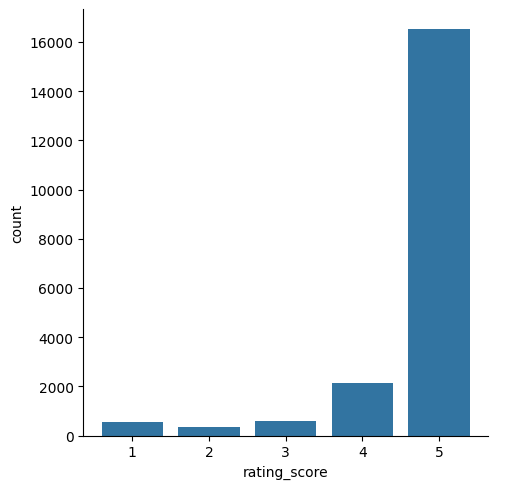

In [48]:
sns.catplot(rb, x='rating_score', kind='count')

In [ ]:
group=rb.groupby(year())